Mounted at /content/drive
X shape: (180, 90) Y shape: (180, 7)
Errors for each of the 7 future days:
 Day +1: RMSE = 3.22, MAE = 2.61
 Day +2: RMSE = 3.68, MAE = 3.07
 Day +3: RMSE = 3.76, MAE = 3.08
 Day +4: RMSE = 4.03, MAE = 3.32
 Day +5: RMSE = 4.44, MAE = 3.62
 Day +6: RMSE = 4.54, MAE = 3.82
 Day +7: RMSE = 4.94, MAE = 4.10


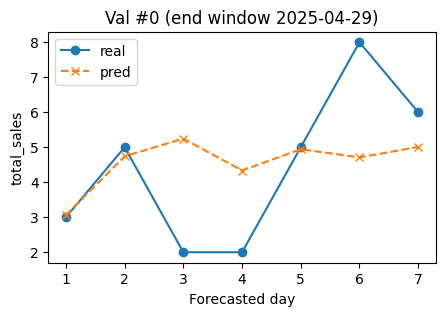

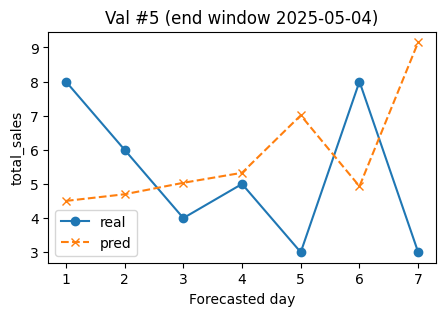

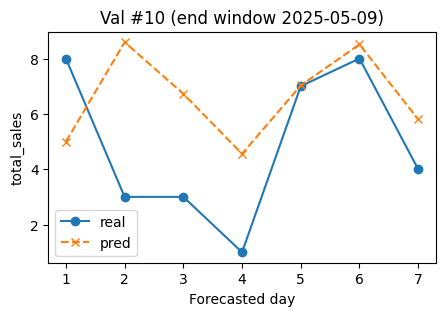

In [4]:
# ─── 1) Drive and libraries ─────────────────────────────────────────────────────
!pip install xgboost --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# ─── 2) Upload and Preprocessing ──────────────────────────────────────────────────
PATH = '/content/drive/MyDrive/ecommerce_dashboard/data/combined_final.csv'
df = pd.read_csv(PATH, parse_dates=['day'])
df = df.set_index('day').asfreq('D')

# Fill in missing sales
df['total_sales'] = df['total_sales'].ffill()

# Exclude rows ignore=True
df = df[df['ignore']==False]

# Create calendar variables
df['dow']     = df.index.dayofweek
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

# We stick to what is strictly necessary
df = df[['total_sales','dow_sin','dow_cos']]


# ─── 3) Sliding windows → features/target  ────────────────────────────────
WINDOW  = 30   # historical days
HORIZON = 7    # days to forecast
FEATS   = ['total_sales','dow_sin','dow_cos']

X_list, Y_list, date_ends = [], [], []
arr = df[FEATS].values
idx = df.index

for i in range(len(arr) - WINDOW - HORIZON + 1):
    # history window (flattened)
    X_list.append(arr[i : i+WINDOW].flatten())
    # target: only column 0 (total_sales) for the next HORIZON days
    Y_list.append(arr[i+WINDOW : i+WINDOW+HORIZON, 0])
  # we save the end date of the window, for graphics
    date_ends.append(idx[i + WINDOW - 1])

X = np.array(X_list)    # (n_samples, WINDOW*3)
Y = np.array(Y_list)    # (n_samples, HORIZON)
date_ends = np.array(date_ends)

print("X shape:", X.shape, "Y shape:", Y.shape)


# ─── 4) Scaler ───────────────────────────────────────────────────────────────
scX = MinMaxScaler().fit(X)
Xs  = scX.transform(X)

scY = MinMaxScaler().fit(Y)
Ys  = scY.transform(Y)


# ─── 5) Split  Train / Val ─────────────────────────────────────────
n = len(Xs)
cut = int(n * 0.8)

Xtr, Xva = Xs[:cut], Xs[cut:]
Ytr, Yva = Ys[:cut], Ys[cut:]
date_va  = date_ends[cut:]


# ─── 6) Train XGBoost multi-output ─────────────────────────────────────────
xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        random_state=42,
        verbosity=0
    )
)
xgb_model.fit(Xtr, Ytr)


# ─── 7) Predict and descale ─────────────────────────────────────────────────
Yva_pred       = xgb_model.predict(Xva)
Yva_pred_real  = scY.inverse_transform(Yva_pred)
Yva_true       = scY.inverse_transform(Yva)


# ─── 8) Metrics by horizon ────────────────────────────────────────────────
print("Errors for each of the 7 future days:")
for h in range(HORIZON):
    rmse = np.sqrt(mean_squared_error(Yva_true[:,h], Yva_pred_real[:,h]))
    mae  = mean_absolute_error(Yva_true[:,h], Yva_pred_real[:,h])
    print(f" Day +{h+1:>1d}: RMSE = {rmse:.2f}, MAE = {mae:.2f}")


# ─── 9) Plot forecast xample  ─────────────────────────────────────────────
def plot_example(idx_ex: int):
    real = Yva_true[idx_ex]
    pred = Yva_pred_real[idx_ex]
    days = np.arange(1, HORIZON+1)
    plt.figure(figsize=(5,3))
    plt.plot(days, real, 'o-', label='real')
    plt.plot(days, pred, 'x--', label='pred')
    plt.title(f"Val #{idx_ex} (end window {date_va[idx_ex].date()})")
    plt.xlabel("Forecasted day"); plt.ylabel("total_sales")
    plt.xticks(days)
    plt.legend()
    plt.show()

for ex in [0, 5, 10]:
    plot_example(ex)

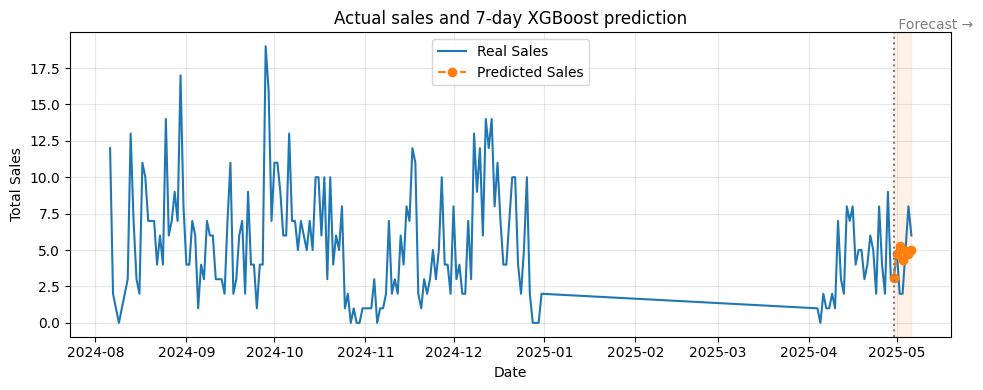

In [5]:
# ─── 10) Build a DataFrame with the actual + predicted series ───────────────────

# 10.1 Full real series (already with daily index)
ventas = df['total_sales']

# 10.2 We take the start date of the validation block
# and concatenate the predictions for the first 7 days after that date
start_pred = date_va[0] + pd.Timedelta(days=1)
pred_index = pd.date_range(start_pred, periods=HORIZON, freq='D')

# 10.3 First prediction block
pred_block = pd.Series(Yva_pred_real[0], index=pred_index)

# 10.4 DataFrame to graph together
plot_df = pd.DataFrame({
    'real': ventas.loc[:pred_index[-1]],
}).join(pred_block.rename('pred'), how='outer')

# ─── 11) Actual plot vs. prediction in zoom ───────────────────────────────────────────

plt.figure(figsize=(10,4))

# 11.1 Real series
plt.plot(plot_df.index, plot_df['real'], label='Real Sales', color='C0')

# 11.2 Forecast (for 7 days)
plt.plot(plot_df.index, plot_df['pred'], 'o--', label='Predicted Sales', color='C1', markersize=6)

# 11.3 Shaded area of the forecast
plt.axvspan(pred_index[0], pred_index[-1], color='C1', alpha=0.1)

# 11.4 Vertical line indicating start of forecast
plt.axvline(pred_index[0], linestyle=':', color='gray')
plt.text(pred_index[0], plt.ylim()[1], ' Forecast →', va='bottom', ha='left', color='gray')

# 11.5 Labels and legend
plt.title('Actual sales and 7-day XGBoost prediction')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

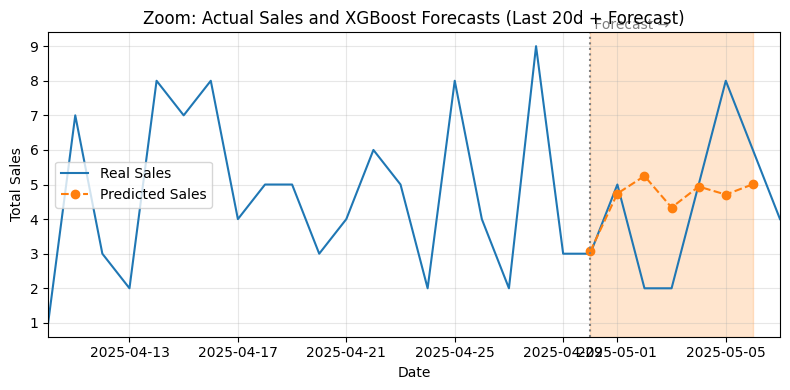

In [6]:
# ─── Assuming you already have:
# df: Original DataFrame with daily index and 'total_sales' column
# date_va: Array of validation window end dates
# Yva_pred_real: Numpy array with descaled actual predictions
# HORIZON = 7

import matplotlib.pyplot as plt
import pandas as pd

# 1) Prepare prediction indices
start_pred = date_va[0] + pd.Timedelta(days=1)
pred_index = pd.date_range(start_pred, periods=HORIZON, freq='D')

# 2) Build the Prediction Series
pred_block = pd.Series(Yva_pred_real[0], index=pred_index)

# 3) Mount the DataFrame for graphing
plot_df = pd.DataFrame({
    'real': df['total_sales']
}).join(pred_block.rename('pred'), how='outer')

# 4) Define the zoom range (e.g. 14 days before to the end of the forecast)
zoom_start = start_pred - pd.Timedelta(days=20)
zoom_end   = pred_index[-1] + pd.Timedelta(days=1)

# 5) Zoom graph
plt.figure(figsize=(8,4))

# Zoom real series
plt.plot(
    plot_df.loc[zoom_start:zoom_end].index,
    plot_df.loc[zoom_start:zoom_end, 'real'],
    color='C0', label='Real Sales'
)

# Forecast
plt.plot(
    plot_df.loc[zoom_start:zoom_end].index,
    plot_df.loc[zoom_start:zoom_end, 'pred'],
    'o--', color='C1', label='Predicted Sales', markersize=6
)

# Forecast block shading
plt.axvspan(pred_index[0], pred_index[-1],
            color='C1', alpha=0.2, label='_nolegend_')

# Vertical line of start forecast
plt.axvline(pred_index[0], linestyle=':', color='gray')
plt.text(pred_index[0], plt.ylim()[1],
         ' Forecast →', va='bottom', ha='left', color='gray')

plt.title('Zoom: Actual Sales and XGBoost Forecasts (Last 20d + Forecast)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(alpha=0.3)

plt.xlim(zoom_start, zoom_end)
plt.tight_layout()
plt.show()